<center><h1>In the name of Allah</h1></center>

Name: *Arash Saleh ahmadi*

Student Number: *401205264*

In this notebook, you will explore adversarial attacks and training methods in deep learning. First, you will train a simple model, ResNet18, on the CIFAR-10 dataset. Next, you will learn about two different adversarial attacks: FGSM (Fast Gradient Sign Method) and PGD (Projected Gradient Descent). To enhance your understanding, you will implement the PGD attack from scratch, while the FGSM attack will be implemented using a library. After this, you will use the FGSM attack to generate adversarial examples and then perform adversarial training on the model using the CIFAR-10 dataset. Finally, you will compare the performance and robustness of the adversarially trained model with the original model.

Good luck!

## outline
- Train Resnet on CIFAR10
- FGSM Attack using torchattacks
- PGD Attack from scratch
- Visualization
- Adversarial Training


In [1]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Train Resnet on CIFAR10 (15 pts)

In [4]:
# Prepare Cifar10 data
batch_size = 128
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


##############################################################################
# Prepare training and test datasets and dataloaders                         #
##############################################################################
traindataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)
# train_size = int(0.8 * len(traindataset))
# val_size = len(trainset) - train_size
# trainset, valset = torch.utils.data.random_split(traindataset, [train_size, val_size])
trainloader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True,num_workers=2)
# validloader = torch.utils.data.DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False,num_workers=2)
################################ End #########################################

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 42843012.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# model architecture
class resnet(nn.Module):
  def __init__(self, num_cls):
    super().__init__()
    self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
    self.fc = nn.Linear(512, num_cls)

  def forward(self, x):
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    return logits

##############################################################################
# Initialize model and move to device                                        #
##############################################################################
model = resnet(len(classes)).to(device)

################################ End #########################################

In [ ]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

In [ ]:
##############################################################################
# Implement train loop and log training loss after each epoch                #
##############################################################################
from tqdm.notebook import tqdm
t_epoch_loss=[]
t_epoch_accuracy=[]
for epoch in range(epochs):
    running_loss=0
    corr=0
    for i,(x,y) in tqdm(enumerate(trainloader),leave=False):
        x,y=x.to(device) , y.to(device)
        output=model(x)
        loss=criterion(output,y)
        running_loss+=loss.item()
        predicted = torch.max(output.data, 1)[1]
        corr+=(predicted == y).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # with torch.no_grad():
    #     v_r_loss=0
    #     v_corr=0

    #     for x_val,y_val in validloader:
    #         x_val,y_val=x_val.to(device),y_val.to(device)
    #         v_output=model(x_val)
    #         v_loss=criterion(v_output,y_val)
    #         v_r_loss+=v_loss.item()
    #         v_predicted = torch.max(v_output.data, 1)[1]
    #         v_corr+=(v_predicted == y_val).sum().item()
    print(f"EPOCH={epoch+1}")
    print(f" ---- train loss=={running_loss/(len(trainloader)):.4f}     -----   train acuracy =={100*corr/(len(trainloader)*batch_size):.2f}")
    # print(f" ---- validation loss=={v_r_loss/(len(validloader)):.4f}    -----   validation acuracy =={100*v_corr/(len(validloader)*batch_size):.2f}")
    print("----------------------------------------------------------------------")
    t_epoch_loss.append(running_loss/len(trainloader))
    t_epoch_accuracy.append(100*corr/(len(trainloader)*batch_size))
    # v_epoch_loss.append(v_r_loss/len(validloader))
################################ End #########################################

0it [00:00, ?it/s]

EPOCH=1
 ---- train loss==1.6938     -----   train acuracy ==38.56
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=2
 ---- train loss==1.3198     -----   train acuracy ==52.12
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=3
 ---- train loss==1.1625     -----   train acuracy ==58.63
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=4
 ---- train loss==1.0482     -----   train acuracy ==62.71
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=5
 ---- train loss==0.9701     -----   train acuracy ==65.74
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=6
 ---- train loss==0.9053     -----   train acuracy ==68.08
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=7
 ---- train loss==0.8556     -----   train acuracy ==69.62
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=8
 ---- train loss==0.8094     -----   train acuracy ==71.40
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=9
 ---- train loss==0.7749     -----   train acuracy ==72.64
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=10
 ---- train loss==0.7391     -----   train acuracy ==73.90
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=11
 ---- train loss==0.7092     -----   train acuracy ==75.16
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=12
 ---- train loss==0.6881     -----   train acuracy ==75.64
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=13
 ---- train loss==0.6684     -----   train acuracy ==76.34
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=14
 ---- train loss==0.6365     -----   train acuracy ==77.37
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=15
 ---- train loss==0.6205     -----   train acuracy ==78.22
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=16
 ---- train loss==0.6011     -----   train acuracy ==78.77
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=17
 ---- train loss==0.5814     -----   train acuracy ==79.33
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=18
 ---- train loss==0.5642     -----   train acuracy ==79.99
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=19
 ---- train loss==0.5503     -----   train acuracy ==80.58
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=20
 ---- train loss==0.5348     -----   train acuracy ==81.10
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=21
 ---- train loss==0.5198     -----   train acuracy ==81.49
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=22
 ---- train loss==0.5068     -----   train acuracy ==82.08
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=23
 ---- train loss==0.4997     -----   train acuracy ==82.26
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=24
 ---- train loss==0.4843     -----   train acuracy ==82.75
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=25
 ---- train loss==0.4754     -----   train acuracy ==82.96
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=26
 ---- train loss==0.4620     -----   train acuracy ==83.66
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=27
 ---- train loss==0.4513     -----   train acuracy ==84.03
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=28
 ---- train loss==0.4388     -----   train acuracy ==84.39
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=29
 ---- train loss==0.4318     -----   train acuracy ==84.67
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=30
 ---- train loss==0.4151     -----   train acuracy ==85.15
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=31
 ---- train loss==0.4054     -----   train acuracy ==85.40
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=32
 ---- train loss==0.4006     -----   train acuracy ==85.56
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=33
 ---- train loss==0.3905     -----   train acuracy ==85.88
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=34
 ---- train loss==0.3873     -----   train acuracy ==86.10
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=35
 ---- train loss==0.3763     -----   train acuracy ==86.55
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=36
 ---- train loss==0.3675     -----   train acuracy ==86.80
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=37
 ---- train loss==0.3562     -----   train acuracy ==87.12
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=38
 ---- train loss==0.3528     -----   train acuracy ==87.22
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=39
 ---- train loss==0.3424     -----   train acuracy ==87.65
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=40
 ---- train loss==0.3309     -----   train acuracy ==88.03
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=41
 ---- train loss==0.3358     -----   train acuracy ==88.03
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=42
 ---- train loss==0.3229     -----   train acuracy ==88.57
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=43
 ---- train loss==0.3174     -----   train acuracy ==88.52
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=44
 ---- train loss==0.3085     -----   train acuracy ==88.94
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=45
 ---- train loss==0.3057     -----   train acuracy ==89.10
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=46
 ---- train loss==0.2961     -----   train acuracy ==89.53
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=47
 ---- train loss==0.2864     -----   train acuracy ==89.58
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=48
 ---- train loss==0.2820     -----   train acuracy ==89.80
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=49
 ---- train loss==0.2737     -----   train acuracy ==90.16
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=50
 ---- train loss==0.2705     -----   train acuracy ==90.02
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=51
 ---- train loss==0.2731     -----   train acuracy ==90.19
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=52
 ---- train loss==0.2639     -----   train acuracy ==90.38
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=53
 ---- train loss==0.2576     -----   train acuracy ==90.70
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=54
 ---- train loss==0.2505     -----   train acuracy ==90.99
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=55
 ---- train loss==0.2442     -----   train acuracy ==91.26
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=56
 ---- train loss==0.2432     -----   train acuracy ==91.19
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=57
 ---- train loss==0.2334     -----   train acuracy ==91.49
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=58
 ---- train loss==0.2309     -----   train acuracy ==91.57
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=59
 ---- train loss==0.2263     -----   train acuracy ==91.78
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=60
 ---- train loss==0.2277     -----   train acuracy ==91.68
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=61
 ---- train loss==0.2179     -----   train acuracy ==92.14
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=62
 ---- train loss==0.2136     -----   train acuracy ==92.27
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=63
 ---- train loss==0.2094     -----   train acuracy ==92.45
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=64
 ---- train loss==0.2089     -----   train acuracy ==92.48
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=65
 ---- train loss==0.1990     -----   train acuracy ==92.80
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=66
 ---- train loss==0.1942     -----   train acuracy ==92.89
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=67
 ---- train loss==0.1925     -----   train acuracy ==92.84
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=68
 ---- train loss==0.1882     -----   train acuracy ==93.07
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=69
 ---- train loss==0.1814     -----   train acuracy ==93.42
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=70
 ---- train loss==0.1832     -----   train acuracy ==93.30
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=71
 ---- train loss==0.1818     -----   train acuracy ==93.34
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=72
 ---- train loss==0.1700     -----   train acuracy ==93.81
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=73
 ---- train loss==0.1735     -----   train acuracy ==93.75
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=74
 ---- train loss==0.1694     -----   train acuracy ==93.85
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=75
 ---- train loss==0.1630     -----   train acuracy ==94.12
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=76
 ---- train loss==0.1598     -----   train acuracy ==94.12
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=77
 ---- train loss==0.1582     -----   train acuracy ==94.19
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=78
 ---- train loss==0.1507     -----   train acuracy ==94.60
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=79
 ---- train loss==0.1537     -----   train acuracy ==94.39
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=80
 ---- train loss==0.1503     -----   train acuracy ==94.59
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=81
 ---- train loss==0.1482     -----   train acuracy ==94.70
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=82
 ---- train loss==0.1464     -----   train acuracy ==94.66
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=83
 ---- train loss==0.1382     -----   train acuracy ==94.99
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=84
 ---- train loss==0.1385     -----   train acuracy ==94.97
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=85
 ---- train loss==0.1313     -----   train acuracy ==95.30
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=86
 ---- train loss==0.1379     -----   train acuracy ==94.97
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=87
 ---- train loss==0.1309     -----   train acuracy ==95.19
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=88
 ---- train loss==0.1351     -----   train acuracy ==95.03
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=89
 ---- train loss==0.1266     -----   train acuracy ==95.43
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=90
 ---- train loss==0.1242     -----   train acuracy ==95.42
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=91
 ---- train loss==0.1211     -----   train acuracy ==95.62
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=92
 ---- train loss==0.1193     -----   train acuracy ==95.64
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=93
 ---- train loss==0.1199     -----   train acuracy ==95.66
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=94
 ---- train loss==0.1181     -----   train acuracy ==95.76
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=95
 ---- train loss==0.1148     -----   train acuracy ==95.72
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=96
 ---- train loss==0.1110     -----   train acuracy ==95.97
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=97
 ---- train loss==0.1052     -----   train acuracy ==96.23
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=98
 ---- train loss==0.1097     -----   train acuracy ==96.06
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=99
 ---- train loss==0.1046     -----   train acuracy ==96.18
----------------------------------------------------------------------


0it [00:00, ?it/s]

EPOCH=100
 ---- train loss==0.1035     -----   train acuracy ==96.17
----------------------------------------------------------------------


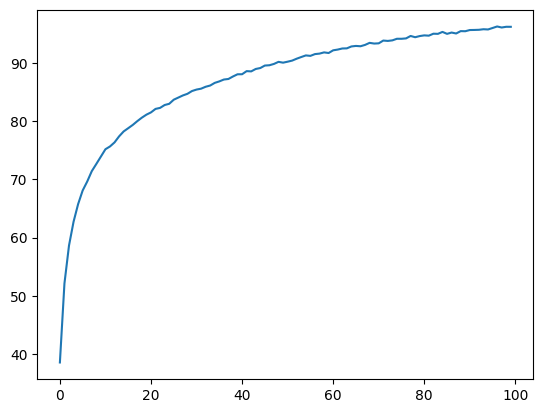

In [ ]:
plt.plot(t_epoch_accuracy)

In [ ]:
##############################################################################
# Evaluate the trained model on test set and print test accuracy             #
##############################################################################
t_r_loss=0
t_corr=0
with torch.no_grad():
    for x_test,y_test in tqdm(testloader):
        x_test,y_test=x_test.to(device),y_test.to(device)

        test_output=model(x_test)

        test_loss=criterion(test_output,y_test)

        t_r_loss+=test_loss.item()

        t_predicted = torch.max(test_output.data, 1)[1]

        t_corr+=(t_predicted == y_test).sum().item()
print(f"loss=={t_r_loss/(len(testloader)):.5f} acuracy =={100*t_corr/(len(testloader)*batch_size)}")


################################ End #########################################

  0%|          | 0/79 [00:00<?, ?it/s]

loss==0.86315 acuracy ==80.00395569620254


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [ ]:
# Save model
model.eval()
model_name = "//content//drive//MyDrive//resnet18_cifar10_model_pretrained.pth"
model_PATH = f"{model_name}"
torch.save(model.state_dict(), model_PATH)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = '/content/drive/MyDrive/resnet18_cifar10_model_pretrained.pth'

# Load the model
model = resnet(len(classes)).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## FGSM Attack using torchattacks (10 pts)

In this section you should run FGSM attack using torchattacks library (https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html).

Run the attack for $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on untargeted FGSM attack on the test data.

In [7]:
import torchattacks
def fgsmattack(net,dataloader,epsilon):
    epsilon = epsilon
    fgsm = torchattacks.FGSM(net, eps=epsilon)


    correct = 0
    total = 0

    net.eval()

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad = True

        adv_inputs = fgsm(inputs, labels)


        outputs = net(adv_inputs)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Accuracy after FGSM attack with epsilon = {epsilon:.4f}: {accuracy:.2f}%')
    return accuracy

In [ ]:
##############################################################################
# run untargeted FGSM attack for epsilon = 1/255 and report its accuracy     #
##############################################################################
epsilon = 1/255
accuracy_of_robusted_model=fgsmattack(model,dataloader=testloader,epsilon=epsilon)




################################ End #########################################

Accuracy after FGSM attack with epsilon = 0.0039: 37.47%


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [ ]:
##############################################################################
# run untargeted FGSM attack for epsilon = 4/255 and report its accuracy     #
##############################################################################

epsilon = 4/255
accuracy_of_robusted_model=fgsmattack(model,dataloader=testloader,epsilon=epsilon)






################################ End #########################################

Accuracy after FGSM attack with epsilon = 0.0157: 35.86%


In [ ]:
##############################################################################
# run untargeted FGSM attack for epsilon = 8/255 and report its accuracy     #
##############################################################################


epsilon = 8/255
accuracy_of_robusted_model=fgsmattack(model,dataloader=testloader,epsilon=epsilon)




################################ End #########################################

Accuracy after FGSM attack with epsilon = 0.0314: 33.67%


## PGD Attack from scratch (30 pts)

In this section you should implement PGD attack from scratch.

In [8]:
class LinfPGDAttack(object):

    def __init__(self, model, epsilon=8/255, k=2, alpha=2/255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha

    def __call__(self, image, label):
        image = image.to(device)
        label = label.to(device)

        out = self.model(image)
        _, pred = torch.max(out, 1)

        perturbed_image = image.clone()
        perturbed_image = perturbed_image.to(device)

        if pred == label:
             ##############################################################################
            # Implement a k step PGD attack of size alpha                                #
            # while always staying within epsilon distance from the initial point        #
            # Use cross entropy loss                                                     #
            ##############################################################################
            perturbed_image.requires_grad = True
            for _ in range(self.steps):
                out = self.model(perturbed_image)
                # print(out.shape)
                # print(label)
                loss = F.cross_entropy(out, label.unsqueeze(0))
                self.model.zero_grad()
                loss.backward()
                grad = perturbed_image.grad.data


                perturbed_image = perturbed_image + self.alpha * grad.sign()
                perturbed_image = torch.clamp(perturbed_image, image - self.epsilon, image + self.epsilon)
                perturbed_image = torch.clamp(perturbed_image, 0, 1)
                perturbed_image = perturbed_image.detach()
                perturbed_image.requires_grad = True

        return perturbed_image


In [ ]:
##############################################################################
# Evaluate PGD attack on the trained model with k=2,4,8                      #
##############################################################################

k_list = [2,4,8]

##############################################################################

# Your code goes here

for k in k_list:
    pgd_attack = LinfPGDAttack(model, k=k)
    correct = 0
    total = 0

    model.eval()

    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        adv_inputs=torch.zeros_like(inputs,device=device)
        for index in range(len(inputs)):

            adv_inputs[index] = pgd_attack(inputs[index].unsqueeze(0), labels[index])


        # adv_inputs = pgd_attack(inputs, labels)

        with torch.no_grad():
            outputs = model(adv_inputs)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Accuracy after PGD attack with k={k}: {accuracy:.2f}%')
################################ End #########################################

Accuracy after PGD attack with k=2: 28.09%


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy after PGD attack with k=4: 19.94%
Accuracy after PGD attack with k=8: 16.52%


## Visualization (10 pts)

Implement a function to plot the original image, the perturbed imaged and their predicted labels by the model

In [ ]:
##############################################################################
# Implement the function described                                           #
##############################################################################
def display_images_and_predictions(orig_img , orig_lab, adv_img, pred_label):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    axes[0].imshow(orig_img.permute(1, 2, 0))
    axes[0].set_title(f"Original Image\nLabel: {classes[orig_lab]}")
    axes[0].axis('off')


    axes[1].imshow(adv_img.detach().permute(1, 2, 0))
    axes[1].set_title(f"Perturbed Image")
    axes[1].axis('off')


    pred_class = torch.argmax(pred_label).item()
    probs = pred_label.detach().cpu().numpy().flatten()
    axes[2].bar(range(10), probs)
    axes[2].set_title(f"Predicted Label: {classes[pred_class]}")
    axes[2].set_xticks(range(10))
    axes[2].set_xticklabels(classes)
    axes[2].set_xlabel("Class")
    axes[2].set_ylabel("Probability")

    plt.tight_layout()
    plt.show()






################################ End #########################################

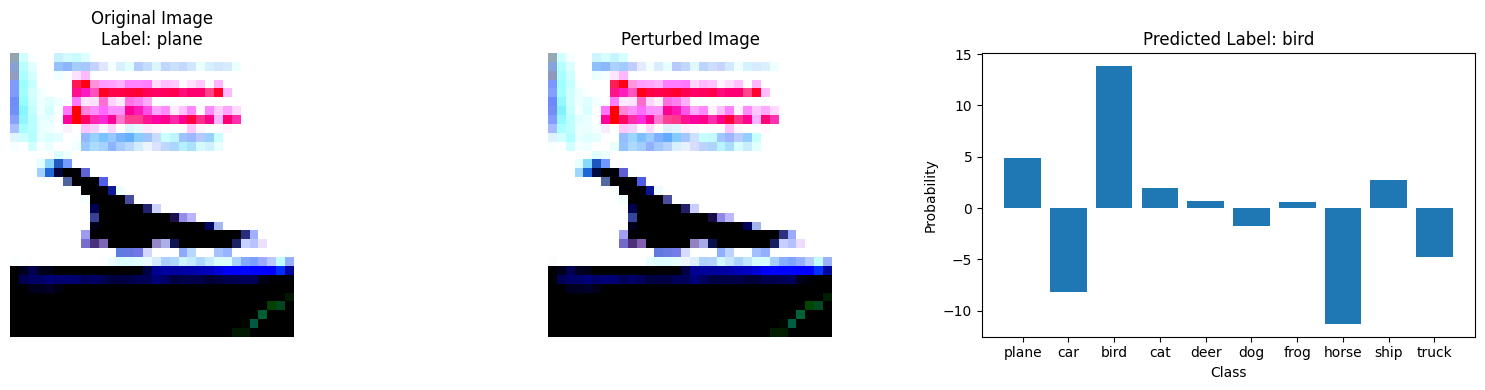

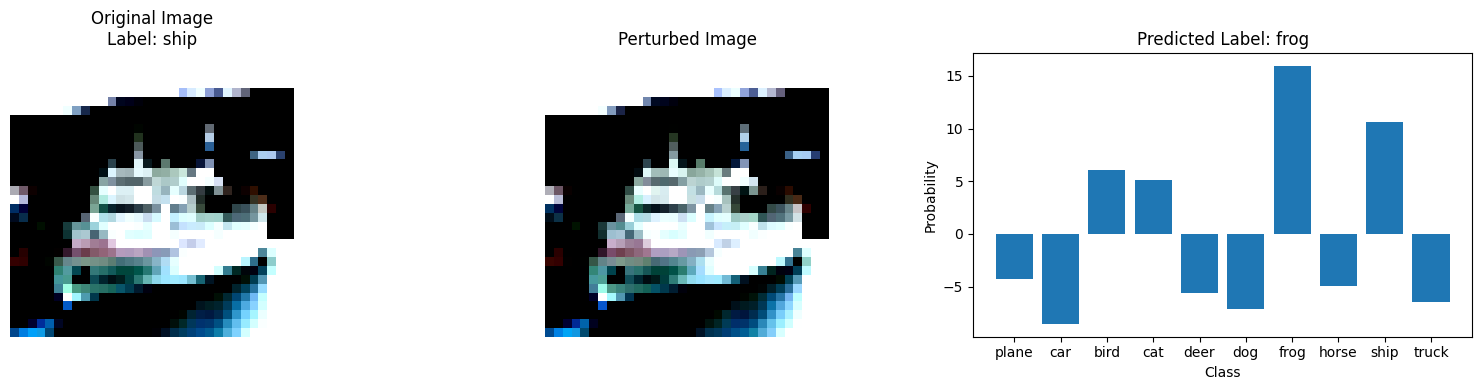

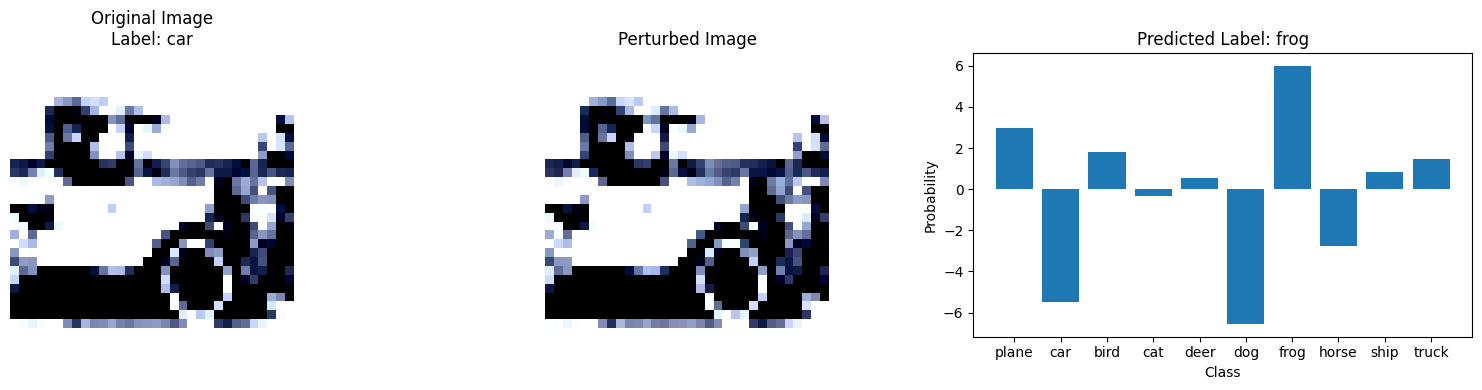

In [ ]:
##############################################################################
# Choose 3 random images from testset and run FGSM attack and visualize      #
##############################################################################


random_indices = torch.randint(0, 200, (3,))
images = []
labels = []
for i in random_indices:
  image = testset[i][0]
  label = testset[i][1]
  images.append(image)
  labels.append(label)


epsilon = 4/255
model.eval()
perturbed_images = []
for j in range(len(images)):
  fgsm = torchattacks.FGSM(model, epsilon)
  perturbed_image = fgsm(images[j].unsqueeze(0), torch.tensor([labels[j]]))
  perturbed_images.append(perturbed_image.squeeze(0))

for b in range(3):
  display_images_and_predictions(images[b].detach().cpu(),labels[b], perturbed_images[b].detach().cpu(),
                                 model(perturbed_images[b].to(device).unsqueeze(0)))






################################ End #########################################

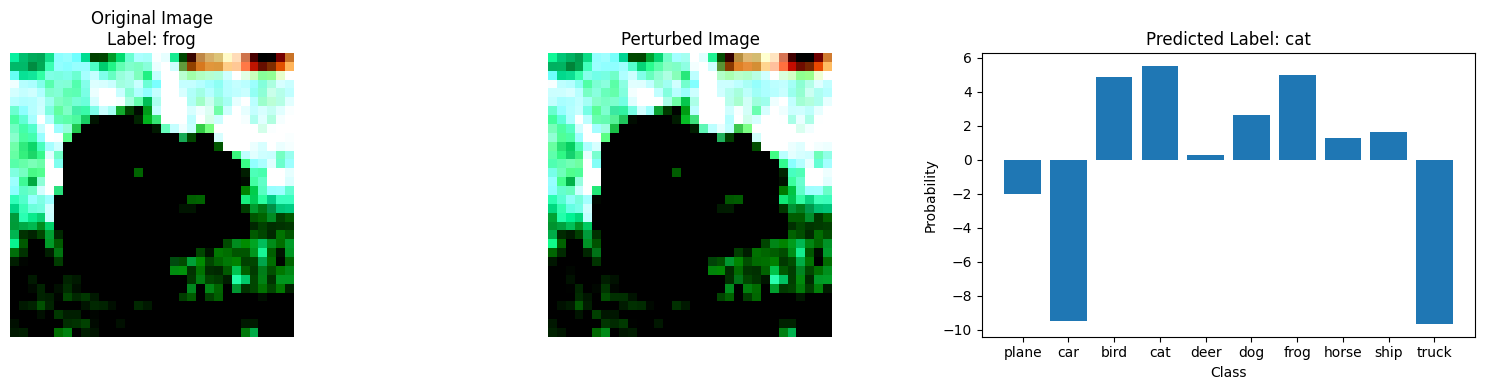

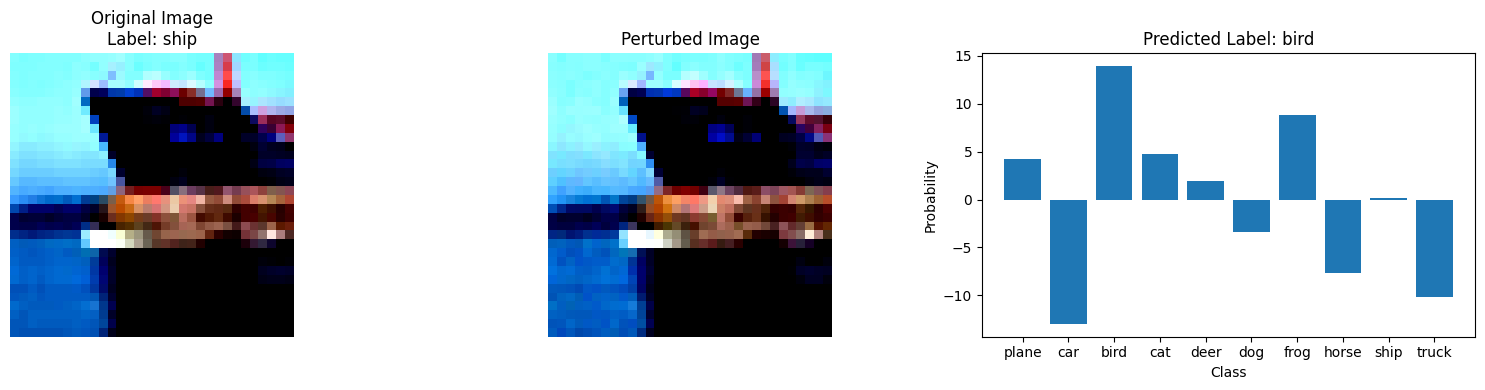

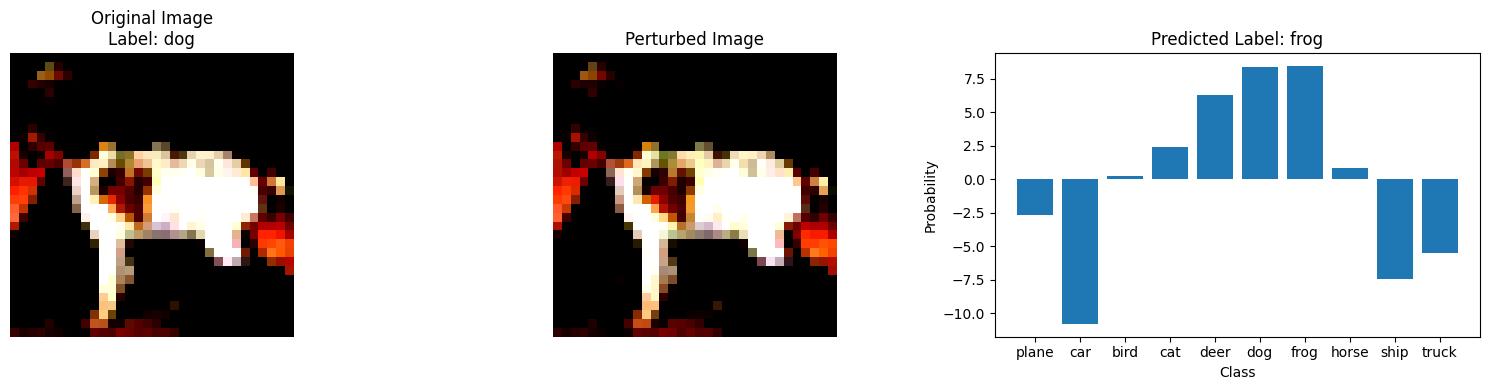

In [ ]:
##############################################################################
# Choose 3 random images from testset and run PGD attack and visualize      #
##############################################################################
random_indices = torch.randint(0, 200, (3,))
images = []
labels = []
for i in random_indices:
  image = testset[i][0]
  label = testset[i][1]
  images.append(image)
  labels.append(label)
pgd_attack = LinfPGDAttack(model, k=8)
model.eval()
perturbed_images = []
for j in range(len(images)):

  perturbed_image = pgd_attack(images[j].unsqueeze(0), torch.tensor([labels[j]]))
  perturbed_images.append(perturbed_image.squeeze(0))
for b in range(3):
  display_images_and_predictions(images[b].detach().cpu(),labels[b], perturbed_images[b].detach().cpu(),
                                 model(perturbed_images[b].to(device).unsqueeze(0)))



################################ End #########################################

## Adversarial Training (35 pts)

In this section you are going to adversarially train your model and see the results.

In [9]:
##############################################################################
# Load a new resnet model for adversarial training                           #
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################

adv_model = resnet(len(classes)).to(device) # Your code goes here
adv_model.to(device)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

epsilon = 8/255
fgsm = torchattacks.FGSM(adv_model, eps=epsilon)
adv_t_epoch_loss=[]
adv_t_epoch_accuracy=[]
for epoch in range(epochs):
    running_loss = 0.0
    corr = 0
    total = 0
    for i, (images, labels) in enumerate(tqdm(trainloader,leave=False)):
        images, labels = images.to(device), labels.to(device)

        perturbed_images = fgsm(images, labels)



        optimizer.zero_grad()
        if epoch%2==0:
            outputs = adv_model(perturbed_images)
        else:
            outputs = adv_model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        predicted = torch.max(outputs.data, 1)[1]
        corr+=(predicted == labels).sum().item()
        running_loss += loss.item()
        total += labels.size(0)
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100. * corr / total
    print(f"EPOCH={epoch+1}")
    print(f" ---- train loss=={epoch_loss:.4f}     -----   train acuracy =={epoch_accuracy:.2f}")
    print("----------------------------------------------------------------------")
# Your code goes here
    adv_t_epoch_loss.append(epoch_loss)
    adv_t_epoch_accuracy.append(epoch_accuracy)
################################ End #########################################

  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


EPOCH=1
 ---- train loss==1.8123     -----   train acuracy ==34.34
----------------------------------------------------------------------


EPOCH=2
 ---- train loss==1.4346     -----   train acuracy ==48.19
----------------------------------------------------------------------


EPOCH=3
 ---- train loss==1.4918     -----   train acuracy ==46.97
----------------------------------------------------------------------


EPOCH=4
 ---- train loss==1.1538     -----   train acuracy ==58.82
----------------------------------------------------------------------


EPOCH=5
 ---- train loss==1.3312     -----   train acuracy ==52.63
----------------------------------------------------------------------


EPOCH=6
 ---- train loss==1.0130     -----   train acuracy ==64.09
----------------------------------------------------------------------


EPOCH=7
 ---- train loss==1.2377     -----   train acuracy ==56.11
----------------------------------------------------------------------


EPOCH=8
 ---- train loss==0.9080     -----   train acuracy ==67.87
----------------------------------------------------------------------


EPOCH=9
 ---- train loss==1.1619     -----   train acuracy ==58.82
----------------------------------------------------------------------


EPOCH=10
 ---- train loss==0.8317     -----   train acuracy ==70.69
----------------------------------------------------------------------


EPOCH=11
 ---- train loss==1.1117     -----   train acuracy ==60.63
----------------------------------------------------------------------


EPOCH=12
 ---- train loss==0.7781     -----   train acuracy ==72.58
----------------------------------------------------------------------


EPOCH=13
 ---- train loss==1.0671     -----   train acuracy ==62.43
----------------------------------------------------------------------


EPOCH=14
 ---- train loss==0.7273     -----   train acuracy ==74.33
----------------------------------------------------------------------


EPOCH=15
 ---- train loss==1.0344     -----   train acuracy ==63.46
----------------------------------------------------------------------


EPOCH=16
 ---- train loss==0.6920     -----   train acuracy ==75.88
----------------------------------------------------------------------


EPOCH=17
 ---- train loss==1.0011     -----   train acuracy ==64.54
----------------------------------------------------------------------


EPOCH=18
 ---- train loss==0.6632     -----   train acuracy ==76.64
----------------------------------------------------------------------


EPOCH=19
 ---- train loss==0.9682     -----   train acuracy ==65.91
----------------------------------------------------------------------


EPOCH=20
 ---- train loss==0.6277     -----   train acuracy ==78.01
----------------------------------------------------------------------


EPOCH=21
 ---- train loss==0.9522     -----   train acuracy ==66.45
----------------------------------------------------------------------


EPOCH=22
 ---- train loss==0.6035     -----   train acuracy ==78.63
----------------------------------------------------------------------


EPOCH=23
 ---- train loss==0.9381     -----   train acuracy ==66.93
----------------------------------------------------------------------


EPOCH=24
 ---- train loss==0.5786     -----   train acuracy ==79.53
----------------------------------------------------------------------


EPOCH=25
 ---- train loss==0.9108     -----   train acuracy ==67.68
----------------------------------------------------------------------


EPOCH=26
 ---- train loss==0.5615     -----   train acuracy ==80.54
----------------------------------------------------------------------


EPOCH=27
 ---- train loss==0.8827     -----   train acuracy ==69.04
----------------------------------------------------------------------


EPOCH=28
 ---- train loss==0.5421     -----   train acuracy ==80.76
----------------------------------------------------------------------


EPOCH=29
 ---- train loss==0.8678     -----   train acuracy ==69.43
----------------------------------------------------------------------


EPOCH=30
 ---- train loss==0.5207     -----   train acuracy ==81.66
----------------------------------------------------------------------


EPOCH=31
 ---- train loss==0.8470     -----   train acuracy ==70.15
----------------------------------------------------------------------


EPOCH=32
 ---- train loss==0.5056     -----   train acuracy ==82.22
----------------------------------------------------------------------


EPOCH=33
 ---- train loss==0.8220     -----   train acuracy ==71.08
----------------------------------------------------------------------


EPOCH=34
 ---- train loss==0.4913     -----   train acuracy ==82.67
----------------------------------------------------------------------


EPOCH=35
 ---- train loss==0.8009     -----   train acuracy ==71.53
----------------------------------------------------------------------


EPOCH=36
 ---- train loss==0.4739     -----   train acuracy ==83.34
----------------------------------------------------------------------


EPOCH=37
 ---- train loss==0.7960     -----   train acuracy ==71.81
----------------------------------------------------------------------


EPOCH=38
 ---- train loss==0.4625     -----   train acuracy ==83.56
----------------------------------------------------------------------


EPOCH=39
 ---- train loss==0.7797     -----   train acuracy ==72.32
----------------------------------------------------------------------


EPOCH=40
 ---- train loss==0.4503     -----   train acuracy ==83.93
----------------------------------------------------------------------


EPOCH=41
 ---- train loss==0.7623     -----   train acuracy ==72.91
----------------------------------------------------------------------


EPOCH=42
 ---- train loss==0.4360     -----   train acuracy ==84.82
----------------------------------------------------------------------


EPOCH=43
 ---- train loss==0.7422     -----   train acuracy ==73.87
----------------------------------------------------------------------


EPOCH=44
 ---- train loss==0.4181     -----   train acuracy ==85.20
----------------------------------------------------------------------


EPOCH=45
 ---- train loss==0.7300     -----   train acuracy ==74.00
----------------------------------------------------------------------


EPOCH=46
 ---- train loss==0.4135     -----   train acuracy ==85.18
----------------------------------------------------------------------


EPOCH=47
 ---- train loss==0.7125     -----   train acuracy ==74.76
----------------------------------------------------------------------


EPOCH=48
 ---- train loss==0.3979     -----   train acuracy ==85.84
----------------------------------------------------------------------


EPOCH=49
 ---- train loss==0.7028     -----   train acuracy ==75.15
----------------------------------------------------------------------


EPOCH=50
 ---- train loss==0.3859     -----   train acuracy ==86.41
----------------------------------------------------------------------


EPOCH=51
 ---- train loss==0.6856     -----   train acuracy ==75.54
----------------------------------------------------------------------


EPOCH=52
 ---- train loss==0.3764     -----   train acuracy ==86.66
----------------------------------------------------------------------


EPOCH=53
 ---- train loss==0.6830     -----   train acuracy ==75.85
----------------------------------------------------------------------


EPOCH=54
 ---- train loss==0.3689     -----   train acuracy ==87.01
----------------------------------------------------------------------


EPOCH=55
 ---- train loss==0.6621     -----   train acuracy ==76.37
----------------------------------------------------------------------


EPOCH=56
 ---- train loss==0.3566     -----   train acuracy ==87.24
----------------------------------------------------------------------


EPOCH=57
 ---- train loss==0.6509     -----   train acuracy ==76.75
----------------------------------------------------------------------


EPOCH=58
 ---- train loss==0.3453     -----   train acuracy ==87.61
----------------------------------------------------------------------


EPOCH=59
 ---- train loss==0.6388     -----   train acuracy ==77.22
----------------------------------------------------------------------


EPOCH=60
 ---- train loss==0.3394     -----   train acuracy ==87.85
----------------------------------------------------------------------


EPOCH=61
 ---- train loss==0.6239     -----   train acuracy ==77.69
----------------------------------------------------------------------


EPOCH=62
 ---- train loss==0.3312     -----   train acuracy ==88.09
----------------------------------------------------------------------


EPOCH=63
 ---- train loss==0.6096     -----   train acuracy ==78.27
----------------------------------------------------------------------


EPOCH=64
 ---- train loss==0.3215     -----   train acuracy ==88.49
----------------------------------------------------------------------


EPOCH=65
 ---- train loss==0.6050     -----   train acuracy ==78.48
----------------------------------------------------------------------


EPOCH=66
 ---- train loss==0.3138     -----   train acuracy ==88.87
----------------------------------------------------------------------


EPOCH=67
 ---- train loss==0.5966     -----   train acuracy ==78.70
----------------------------------------------------------------------


EPOCH=68
 ---- train loss==0.3015     -----   train acuracy ==89.23
----------------------------------------------------------------------


EPOCH=69
 ---- train loss==0.5842     -----   train acuracy ==79.20
----------------------------------------------------------------------


EPOCH=70
 ---- train loss==0.2987     -----   train acuracy ==89.24
----------------------------------------------------------------------


EPOCH=71
 ---- train loss==0.5723     -----   train acuracy ==79.61
----------------------------------------------------------------------


EPOCH=72
 ---- train loss==0.2902     -----   train acuracy ==89.55
----------------------------------------------------------------------


EPOCH=73
 ---- train loss==0.5609     -----   train acuracy ==80.05
----------------------------------------------------------------------


EPOCH=74
 ---- train loss==0.2846     -----   train acuracy ==89.80
----------------------------------------------------------------------


EPOCH=75
 ---- train loss==0.5485     -----   train acuracy ==80.43
----------------------------------------------------------------------


EPOCH=76
 ---- train loss==0.2724     -----   train acuracy ==90.16
----------------------------------------------------------------------


EPOCH=77
 ---- train loss==0.5371     -----   train acuracy ==80.72
----------------------------------------------------------------------


EPOCH=78
 ---- train loss==0.2673     -----   train acuracy ==90.40
----------------------------------------------------------------------


EPOCH=79
 ---- train loss==0.5288     -----   train acuracy ==81.22
----------------------------------------------------------------------


EPOCH=80
 ---- train loss==0.2614     -----   train acuracy ==90.63
----------------------------------------------------------------------


EPOCH=81
 ---- train loss==0.5218     -----   train acuracy ==81.58
----------------------------------------------------------------------


EPOCH=82
 ---- train loss==0.2581     -----   train acuracy ==90.78
----------------------------------------------------------------------


EPOCH=83
 ---- train loss==0.5065     -----   train acuracy ==81.99
----------------------------------------------------------------------


EPOCH=84
 ---- train loss==0.2485     -----   train acuracy ==91.10
----------------------------------------------------------------------


EPOCH=85
 ---- train loss==0.4960     -----   train acuracy ==82.29
----------------------------------------------------------------------


EPOCH=86
 ---- train loss==0.2392     -----   train acuracy ==91.58
----------------------------------------------------------------------


EPOCH=87
 ---- train loss==0.4883     -----   train acuracy ==82.36
----------------------------------------------------------------------


EPOCH=88
 ---- train loss==0.2360     -----   train acuracy ==91.57
----------------------------------------------------------------------


EPOCH=89
 ---- train loss==0.4747     -----   train acuracy ==82.91
----------------------------------------------------------------------


EPOCH=90
 ---- train loss==0.2300     -----   train acuracy ==91.84
----------------------------------------------------------------------


EPOCH=91
 ---- train loss==0.4712     -----   train acuracy ==83.13
----------------------------------------------------------------------


EPOCH=92
 ---- train loss==0.2235     -----   train acuracy ==92.02
----------------------------------------------------------------------


EPOCH=93
 ---- train loss==0.4583     -----   train acuracy ==83.62
----------------------------------------------------------------------


EPOCH=94
 ---- train loss==0.2212     -----   train acuracy ==91.98
----------------------------------------------------------------------


EPOCH=95
 ---- train loss==0.4555     -----   train acuracy ==83.77
----------------------------------------------------------------------


EPOCH=96
 ---- train loss==0.2112     -----   train acuracy ==92.51
----------------------------------------------------------------------


EPOCH=97
 ---- train loss==0.4442     -----   train acuracy ==84.04
----------------------------------------------------------------------


EPOCH=98
 ---- train loss==0.2107     -----   train acuracy ==92.42
----------------------------------------------------------------------


EPOCH=99
 ---- train loss==0.4447     -----   train acuracy ==83.99
----------------------------------------------------------------------


EPOCH=100
 ---- train loss==0.2022     -----   train acuracy ==92.70
----------------------------------------------------------------------


In [10]:
model.eval()
model_name = "//content//drive//MyDrive//adv1_resnet18_cifar10_model_pretrained.pth"
model_PATH = f"{model_name}"
torch.save(adv_model.state_dict(), model_PATH)

In [11]:
epochs = 100

epsilon = 8/255
fgsm = torchattacks.FGSM(adv_model, eps=epsilon)

for epoch in range(epochs):
    running_loss = 0.0
    corr = 0
    total = 0
    for i, (images, labels) in enumerate(tqdm(trainloader,leave=False)):
        images, labels = images.to(device), labels.to(device)

        perturbed_images = fgsm(images, labels)



        optimizer.zero_grad()
        if epoch%2==0:
            outputs = adv_model(perturbed_images)
        else:
            outputs = adv_model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        predicted = torch.max(outputs.data, 1)[1]
        corr+=(predicted == labels).sum().item()
        running_loss += loss.item()
        total += labels.size(0)
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100. * corr / total
    print(f"EPOCH={epoch+100}")
    print(f" ---- train loss=={epoch_loss:.4f}     -----   train acuracy =={epoch_accuracy:.2f}")
    print("----------------------------------------------------------------------")
# Your code goes here
    adv_t_epoch_loss.append(epoch_loss)
    adv_t_epoch_accuracy.append(epoch_accuracy)

EPOCH=100
 ---- train loss==0.4284     -----   train acuracy ==84.50
----------------------------------------------------------------------


EPOCH=101
 ---- train loss==0.1915     -----   train acuracy ==93.19
----------------------------------------------------------------------


EPOCH=102
 ---- train loss==0.4248     -----   train acuracy ==84.75
----------------------------------------------------------------------


EPOCH=103
 ---- train loss==0.1916     -----   train acuracy ==93.21
----------------------------------------------------------------------


EPOCH=104
 ---- train loss==0.4193     -----   train acuracy ==85.06
----------------------------------------------------------------------


EPOCH=105
 ---- train loss==0.1896     -----   train acuracy ==93.09
----------------------------------------------------------------------


EPOCH=106
 ---- train loss==0.3995     -----   train acuracy ==85.60
----------------------------------------------------------------------


EPOCH=107
 ---- train loss==0.1815     -----   train acuracy ==93.38
----------------------------------------------------------------------


EPOCH=108
 ---- train loss==0.4047     -----   train acuracy ==85.46
----------------------------------------------------------------------


EPOCH=109
 ---- train loss==0.1768     -----   train acuracy ==93.69
----------------------------------------------------------------------


EPOCH=110
 ---- train loss==0.3973     -----   train acuracy ==85.76
----------------------------------------------------------------------


EPOCH=111
 ---- train loss==0.1711     -----   train acuracy ==93.87
----------------------------------------------------------------------


EPOCH=112
 ---- train loss==0.3866     -----   train acuracy ==86.14
----------------------------------------------------------------------


EPOCH=113
 ---- train loss==0.1721     -----   train acuracy ==93.88
----------------------------------------------------------------------


EPOCH=114
 ---- train loss==0.3827     -----   train acuracy ==86.38
----------------------------------------------------------------------


EPOCH=115
 ---- train loss==0.1671     -----   train acuracy ==94.05
----------------------------------------------------------------------


EPOCH=116
 ---- train loss==0.3697     -----   train acuracy ==86.73
----------------------------------------------------------------------


EPOCH=117
 ---- train loss==0.1636     -----   train acuracy ==94.22
----------------------------------------------------------------------


EPOCH=118
 ---- train loss==0.3734     -----   train acuracy ==86.66
----------------------------------------------------------------------


EPOCH=119
 ---- train loss==0.1582     -----   train acuracy ==94.35
----------------------------------------------------------------------


EPOCH=120
 ---- train loss==0.3614     -----   train acuracy ==87.07
----------------------------------------------------------------------


EPOCH=121
 ---- train loss==0.1580     -----   train acuracy ==94.40
----------------------------------------------------------------------


EPOCH=122
 ---- train loss==0.3565     -----   train acuracy ==87.15
----------------------------------------------------------------------


EPOCH=123
 ---- train loss==0.1490     -----   train acuracy ==94.59
----------------------------------------------------------------------


EPOCH=124
 ---- train loss==0.3512     -----   train acuracy ==87.48
----------------------------------------------------------------------


EPOCH=125
 ---- train loss==0.1475     -----   train acuracy ==94.77
----------------------------------------------------------------------


EPOCH=126
 ---- train loss==0.3385     -----   train acuracy ==87.91
----------------------------------------------------------------------


EPOCH=127
 ---- train loss==0.1461     -----   train acuracy ==94.80
----------------------------------------------------------------------


EPOCH=128
 ---- train loss==0.3306     -----   train acuracy ==88.27
----------------------------------------------------------------------


EPOCH=129
 ---- train loss==0.1430     -----   train acuracy ==94.90
----------------------------------------------------------------------


EPOCH=130
 ---- train loss==0.3292     -----   train acuracy ==88.23
----------------------------------------------------------------------


EPOCH=131
 ---- train loss==0.1394     -----   train acuracy ==94.98
----------------------------------------------------------------------


EPOCH=132
 ---- train loss==0.3264     -----   train acuracy ==88.20
----------------------------------------------------------------------


EPOCH=133
 ---- train loss==0.1341     -----   train acuracy ==95.28
----------------------------------------------------------------------


EPOCH=134
 ---- train loss==0.3174     -----   train acuracy ==88.67
----------------------------------------------------------------------


EPOCH=135
 ---- train loss==0.1340     -----   train acuracy ==95.27
----------------------------------------------------------------------


EPOCH=136
 ---- train loss==0.3144     -----   train acuracy ==88.82
----------------------------------------------------------------------


EPOCH=137
 ---- train loss==0.1316     -----   train acuracy ==95.33
----------------------------------------------------------------------


EPOCH=138
 ---- train loss==0.3116     -----   train acuracy ==88.72
----------------------------------------------------------------------


EPOCH=139
 ---- train loss==0.1290     -----   train acuracy ==95.40
----------------------------------------------------------------------


EPOCH=140
 ---- train loss==0.3045     -----   train acuracy ==89.10
----------------------------------------------------------------------


EPOCH=141
 ---- train loss==0.1231     -----   train acuracy ==95.63
----------------------------------------------------------------------


EPOCH=142
 ---- train loss==0.2951     -----   train acuracy ==89.56
----------------------------------------------------------------------


EPOCH=143
 ---- train loss==0.1268     -----   train acuracy ==95.52
----------------------------------------------------------------------


EPOCH=144
 ---- train loss==0.2978     -----   train acuracy ==89.34
----------------------------------------------------------------------


EPOCH=145
 ---- train loss==0.1170     -----   train acuracy ==95.88
----------------------------------------------------------------------


EPOCH=146
 ---- train loss==0.2927     -----   train acuracy ==89.62
----------------------------------------------------------------------


EPOCH=147
 ---- train loss==0.1185     -----   train acuracy ==95.68
----------------------------------------------------------------------


EPOCH=148
 ---- train loss==0.2788     -----   train acuracy ==90.07
----------------------------------------------------------------------


EPOCH=149
 ---- train loss==0.1121     -----   train acuracy ==96.02
----------------------------------------------------------------------


EPOCH=150
 ---- train loss==0.2761     -----   train acuracy ==90.00
----------------------------------------------------------------------


EPOCH=151
 ---- train loss==0.1159     -----   train acuracy ==95.89
----------------------------------------------------------------------


EPOCH=152
 ---- train loss==0.2782     -----   train acuracy ==90.17
----------------------------------------------------------------------


EPOCH=153
 ---- train loss==0.1153     -----   train acuracy ==95.88
----------------------------------------------------------------------


EPOCH=154
 ---- train loss==0.2700     -----   train acuracy ==90.30
----------------------------------------------------------------------


EPOCH=155
 ---- train loss==0.1100     -----   train acuracy ==96.09
----------------------------------------------------------------------


EPOCH=156
 ---- train loss==0.2699     -----   train acuracy ==90.55
----------------------------------------------------------------------


EPOCH=157
 ---- train loss==0.1053     -----   train acuracy ==96.24
----------------------------------------------------------------------


EPOCH=158
 ---- train loss==0.2594     -----   train acuracy ==90.81
----------------------------------------------------------------------


EPOCH=159
 ---- train loss==0.1022     -----   train acuracy ==96.40
----------------------------------------------------------------------


EPOCH=160
 ---- train loss==0.2565     -----   train acuracy ==90.76
----------------------------------------------------------------------


EPOCH=161
 ---- train loss==0.1046     -----   train acuracy ==96.36
----------------------------------------------------------------------


EPOCH=162
 ---- train loss==0.2565     -----   train acuracy ==90.71
----------------------------------------------------------------------


EPOCH=163
 ---- train loss==0.0996     -----   train acuracy ==96.48
----------------------------------------------------------------------


EPOCH=164
 ---- train loss==0.2482     -----   train acuracy ==91.04
----------------------------------------------------------------------


EPOCH=165
 ---- train loss==0.0990     -----   train acuracy ==96.49
----------------------------------------------------------------------


EPOCH=166
 ---- train loss==0.2474     -----   train acuracy ==91.16
----------------------------------------------------------------------


EPOCH=167
 ---- train loss==0.0951     -----   train acuracy ==96.62
----------------------------------------------------------------------


EPOCH=168
 ---- train loss==0.2391     -----   train acuracy ==91.38
----------------------------------------------------------------------


EPOCH=169
 ---- train loss==0.0985     -----   train acuracy ==96.64
----------------------------------------------------------------------


EPOCH=170
 ---- train loss==0.2339     -----   train acuracy ==91.63
----------------------------------------------------------------------


EPOCH=171
 ---- train loss==0.0917     -----   train acuracy ==96.75
----------------------------------------------------------------------


EPOCH=172
 ---- train loss==0.2307     -----   train acuracy ==91.73
----------------------------------------------------------------------


EPOCH=173
 ---- train loss==0.0923     -----   train acuracy ==96.75
----------------------------------------------------------------------


EPOCH=174
 ---- train loss==0.2266     -----   train acuracy ==91.98
----------------------------------------------------------------------


EPOCH=175
 ---- train loss==0.0899     -----   train acuracy ==96.75
----------------------------------------------------------------------


EPOCH=176
 ---- train loss==0.2278     -----   train acuracy ==91.77
----------------------------------------------------------------------


EPOCH=177
 ---- train loss==0.0907     -----   train acuracy ==96.81
----------------------------------------------------------------------


EPOCH=178
 ---- train loss==0.2213     -----   train acuracy ==92.18
----------------------------------------------------------------------


EPOCH=179
 ---- train loss==0.0862     -----   train acuracy ==96.96
----------------------------------------------------------------------


EPOCH=180
 ---- train loss==0.2176     -----   train acuracy ==92.28
----------------------------------------------------------------------


EPOCH=181
 ---- train loss==0.0865     -----   train acuracy ==96.92
----------------------------------------------------------------------


EPOCH=182
 ---- train loss==0.2161     -----   train acuracy ==92.21
----------------------------------------------------------------------


EPOCH=183
 ---- train loss==0.0843     -----   train acuracy ==97.02
----------------------------------------------------------------------


EPOCH=184
 ---- train loss==0.2107     -----   train acuracy ==92.39
----------------------------------------------------------------------


EPOCH=185
 ---- train loss==0.0828     -----   train acuracy ==97.06
----------------------------------------------------------------------


EPOCH=186
 ---- train loss==0.2081     -----   train acuracy ==92.62
----------------------------------------------------------------------


EPOCH=187
 ---- train loss==0.0784     -----   train acuracy ==97.22
----------------------------------------------------------------------


EPOCH=188
 ---- train loss==0.2090     -----   train acuracy ==92.54
----------------------------------------------------------------------


EPOCH=189
 ---- train loss==0.0766     -----   train acuracy ==97.35
----------------------------------------------------------------------


EPOCH=190
 ---- train loss==0.2007     -----   train acuracy ==92.97
----------------------------------------------------------------------


EPOCH=191
 ---- train loss==0.0792     -----   train acuracy ==97.26
----------------------------------------------------------------------


EPOCH=192
 ---- train loss==0.2012     -----   train acuracy ==92.79
----------------------------------------------------------------------


EPOCH=193
 ---- train loss==0.0796     -----   train acuracy ==97.24
----------------------------------------------------------------------


EPOCH=194
 ---- train loss==0.1949     -----   train acuracy ==93.07
----------------------------------------------------------------------


EPOCH=195
 ---- train loss==0.0764     -----   train acuracy ==97.26
----------------------------------------------------------------------


EPOCH=196
 ---- train loss==0.1899     -----   train acuracy ==93.23
----------------------------------------------------------------------


EPOCH=197
 ---- train loss==0.0751     -----   train acuracy ==97.34
----------------------------------------------------------------------


EPOCH=198
 ---- train loss==0.1934     -----   train acuracy ==93.22
----------------------------------------------------------------------


EPOCH=199
 ---- train loss==0.0738     -----   train acuracy ==97.47
----------------------------------------------------------------------


In [12]:
model.eval()
model_name = "//content//drive//MyDrive//adv2_resnet18_cifar10_model_pretrained.pth"
model_PATH = f"{model_name}"
torch.save(adv_model.state_dict(), model_PATH)

Text(0.5, 1.0, 'adv training accuracy on train datasets + perturb datasets')

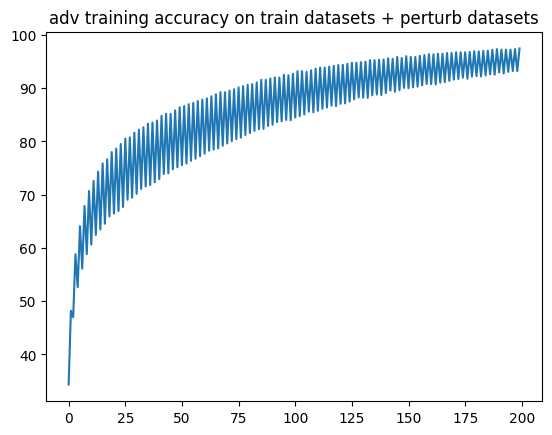

In [17]:
import matplotlib.pyplot as plt
plt.plot(adv_t_epoch_accuracy)
plt.title("adv training accuracy on train datasets + perturb datasets")

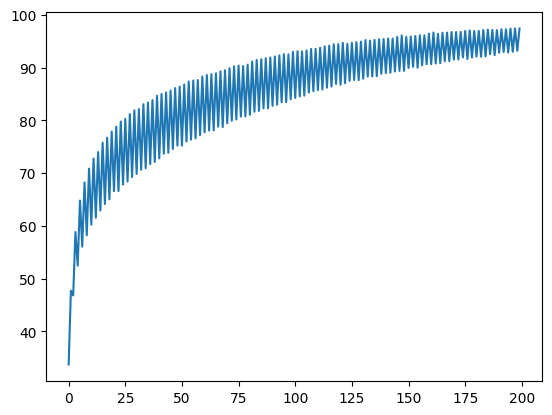

In [ ]:
import matplotlib.pyplot as plt
plt.plot(adv_t_epoch_accuracy)
plt.title("adv training accuracy on train datasets + perturb datasets")

accuracy on perturb test dataset

In [15]:
##############################################################################
# Evaluate the new model on the test dataset                                 #
##############################################################################

# Your code goes here
t_r_loss=0
t_corr=0

for x_test,y_test in tqdm(testloader):
        x_test,y_test=x_test.to(device),y_test.to(device)

        perturbed_images = fgsm(x_test, y_test)
        with torch.no_grad():
            test_output=adv_model(perturbed_images)

            test_loss=criterion(test_output,y_test)

        t_r_loss+=test_loss.item()

        t_predicted = torch.max(test_output.data, 1)[1]

        t_corr+=(t_predicted == y_test).sum().item()
print(f"loss=={t_r_loss/(len(testloader)):.5f} acuracy =={100*t_corr/(len(testloader)*batch_size)}")

################################ End #########################################

100%|██████████| 79/79 [00:03<00:00, 21.25it/s]

loss==1.60086 acuracy ==68.01819620253164


accuracy on original test dataset

In [14]:
t_r_loss=0
t_corr=0

for x_test,y_test in tqdm(testloader):
        x_test,y_test=x_test.to(device),y_test.to(device)

       # perturbed_images = fgsm(x_test, y_test)
        with torch.no_grad():
            test_output=adv_model(x_test)

            test_loss=criterion(test_output,y_test)

        t_r_loss+=test_loss.item()

        t_predicted = torch.max(test_output.data, 1)[1]

        t_corr+=(t_predicted == y_test).sum().item()
print(f"loss=={t_r_loss/(len(testloader)):.5f} acuracy =={100*t_corr/(len(testloader)*batch_size)}")

100%|██████████| 79/79 [00:03<00:00, 24.15it/s]

loss==0.81383 acuracy ==81.45767405063292


In [ ]:
model.eval()
model_name = "//content//drive//MyDrive//adv1_resnet18_cifar10_model_pretrained.pth"
model_PATH = f"{model_name}"
torch.save(adv_model.state_dict(), model_PATH)

In [ ]:
model_path = "//content//drive//MyDrive//adv1_resnet18_cifar10_model_pretrained.pth"

# Load the model
adv_model = resnet(len(classes)).to(device)
adv_model.load_state_dict(torch.load(model_path))

In [16]:
##############################################################################
# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #
##############################################################################
epsilon = 8/255
accuracy_of_robusted_model=fgsmattack(adv_model,dataloader=testloader,epsilon=epsilon)
# Your code goes here

################################ End #########################################

Accuracy after FGSM attack with epsilon = 0.0314: 70.60%


In [13]:
##############################################################################
#  Run PGD attack on the adversarially trained model with k=4                #
##############################################################################
k_list = [4]

##############################################################################

# Your code goes here

for k in k_list:
    pgd_attack = LinfPGDAttack(model, k=k)
    correct = 0
    total = 0

    model.eval()

    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        adv_inputs=torch.zeros_like(inputs,device=device)
        for index in range(len(inputs)):

            adv_inputs[index] = pgd_attack(inputs[index].unsqueeze(0), labels[index])


        # adv_inputs = pgd_attack(inputs, labels)

        with torch.no_grad():
            outputs = adv_model(adv_inputs)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Accuracy after PGD attack with k={k}: {accuracy:.2f}%')
# Your code goes here

################################ End #########################################

Accuracy after PGD attack with k=4: 76.32%


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Answer the following questions:
- What happened to the accuracy of the adversarially trained model?
- What do you conclude from the result of the FGSM attack on the adversarially trained model?
- What do you conclude from the result of the PGD attack on the adversarially trained model?
- What is you final conclusion?

### ANSWERS
1-As can be seen, the accuracy of the adversarially trained model for the training data takes 200 epochs (twice the number of epochs used in usual training) to reach near the usual trained model. However, for the test dataset, the accuracy is very low (almost half of the usually trained model).

2-After the FGSM attack, the accuracy dropped to about 37%, and by increasing the epsilon, the accuracy dropped even more. However, changes in epsilon do not significantly affect the accuracy.

3-After the PGD attack, the accuracy dropped by about 32%. Choosing a higher K results in a much larger change in accuracy, and with K=8, the accuracy is less than 20%.

4- Both attacks are effective and do not perturb the images enough to be noticeable by human eyes. However, the PGD attack proved to be stronger due to being an iterative attack(fsgm is one step attack).

Text(0.5, 1.0, 'Accuracy for Train Dataset')

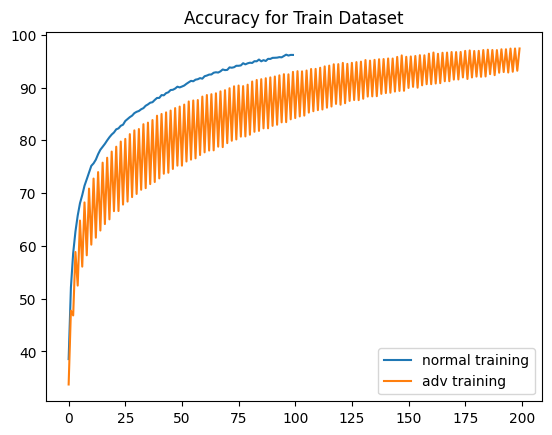

In [ ]:
plt.plot(t_epoch_accuracy,label="normal training")
plt.plot(adv_t_epoch_accuracy,label="adv training")
plt.legend()
plt.title("Accuracy for Train Dataset")